In [7]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from albumentations import Compose, HorizontalFlip, Rotate, Resize
from albumentations.pytorch import ToTensorV2

In [8]:
class LungDataset(Dataset):
    def __init__(self, data_paths):
        self.data_paths = data_paths
        self.label2id = {label: id for id, label in enumerate([
            "Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"
        ])}

    def __getitem__(self, index):
        image_path = self.data_paths[index]
        label = Path(image_path).parent.name
        transform = Compose([
            HorizontalFlip(p=0.5),
            Rotate(limit=10, p=0.25),
            Resize(256, 256),
            ToTensorV2()
        ])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transform(image=image)["image"]
        label_id = self.label2id[label]
        return image.float(), torch.tensor(label_id, dtype=torch.long)

    def __len__(self):
        return len(self.data_paths)

In [9]:
class LungClassificationModel(torch.nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.backbone = models.mobilenet_v2(pretrained=True).features
        self.fc = torch.nn.Linear(1280, num_classes)  # 1280 is the number of features before classifier in MobileNetV2

    def forward(self, x):
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return self.fc(x)

In [13]:
# Define data paths and load data
data_path = 'C:\\Users\\fatme\\OneDrive\\Desktop\\data\\lung_disease_dataset'
train_data_path = glob(f"{data_path}/train/**/*.jpeg", recursive=True)
val_data_path = glob(f"{data_path}/val/**/*.jpeg", recursive=True)
test_data_path = glob(f"{data_path}/test/**/*.jpeg", recursive=True)

train_ds = LungDataset(train_data_path)
val_ds = LungDataset(val_data_path)
test_ds = LungDataset(test_data_path)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)
test_dl = DataLoader(test_ds, batch_size=4)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LungClassificationModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)
criterion = torch.nn.CrossEntropyLoss()

c:\Users\fatme\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fatme\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\fatme/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 9.77MB/s]


In [15]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in tqdm(train_dl, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    # Calculate training loss and accuracy
    epoch_train_loss = train_loss / len(train_dl)
    epoch_train_accuracy = train_correct / len(train_dl.dataset)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_dl, desc=f"Epoch {epoch+1} Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

    # Calculate validation loss and accuracy
    epoch_val_loss = val_loss / len(val_dl)
    epoch_val_accuracy = val_correct / len(val_dl.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Print the epoch's results
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

# Test the model
def test_model(test_dl, model):
    model.eval()
    test_loss, test_correct = 0, 0
    test_labels, test_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            test_correct += (preds == labels).type(torch.float).sum().item()
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    test_accuracy = test_correct / len(test_dl.dataset)
    test_f1_score = f1_score(test_labels, test_preds, average='weighted')
    return test_loss / len(test_dl), test_accuracy, test_f1_score

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1_score = test_model(test_dl, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")

Epoch 1 Validation: 100%|██████████| 397/397 [00:59<00:00,  6.64it/s]


Epoch 1/10 - Training Loss: 0.7587, Training Accuracy: 0.6928, Validation Loss: 0.4468, Validation Accuracy: 0.8242


Epoch 2 Validation: 100%|██████████| 397/397 [00:49<00:00,  8.04it/s]


Epoch 2/10 - Training Loss: 0.5611, Training Accuracy: 0.7781, Validation Loss: 0.4468, Validation Accuracy: 0.8217


Epoch 3 Validation: 100%|██████████| 397/397 [00:50<00:00,  7.94it/s]


Epoch 3/10 - Training Loss: 0.4977, Training Accuracy: 0.8030, Validation Loss: 0.4023, Validation Accuracy: 0.8494


Epoch 4 Validation: 100%|██████████| 397/397 [00:49<00:00,  8.00it/s]


Epoch 4/10 - Training Loss: 0.4372, Training Accuracy: 0.8250, Validation Loss: 0.3596, Validation Accuracy: 0.8633


Epoch 5 Validation: 100%|██████████| 397/397 [00:50<00:00,  7.79it/s]


Epoch 5/10 - Training Loss: 0.4246, Training Accuracy: 0.8296, Validation Loss: 0.5203, Validation Accuracy: 0.7782


Epoch 6 Validation: 100%|██████████| 397/397 [00:50<00:00,  7.82it/s]


Epoch 6/10 - Training Loss: 0.3908, Training Accuracy: 0.8482, Validation Loss: 0.4523, Validation Accuracy: 0.8292


Epoch 7 Validation: 100%|██████████| 397/397 [00:50<00:00,  7.89it/s]


Epoch 7/10 - Training Loss: 0.3691, Training Accuracy: 0.8528, Validation Loss: 0.4662, Validation Accuracy: 0.8141


Epoch 8 Validation: 100%|██████████| 397/397 [00:49<00:00,  7.98it/s]


Epoch 8/10 - Training Loss: 0.3624, Training Accuracy: 0.8551, Validation Loss: 0.3936, Validation Accuracy: 0.8412


Epoch 9 Validation: 100%|██████████| 397/397 [00:49<00:00,  8.05it/s]


Epoch 9/10 - Training Loss: 0.3393, Training Accuracy: 0.8595, Validation Loss: 0.3447, Validation Accuracy: 0.8652


Epoch 10 Validation: 100%|██████████| 397/397 [00:49<00:00,  7.94it/s]


Epoch 10/10 - Training Loss: 0.3289, Training Accuracy: 0.8613, Validation Loss: 0.4510, Validation Accuracy: 0.8154


Testing: 100%|██████████| 398/398 [00:59<00:00,  6.66it/s]

Test Loss: 0.4200, Test Accuracy: 0.8258, Test F1 Score: 0.8279


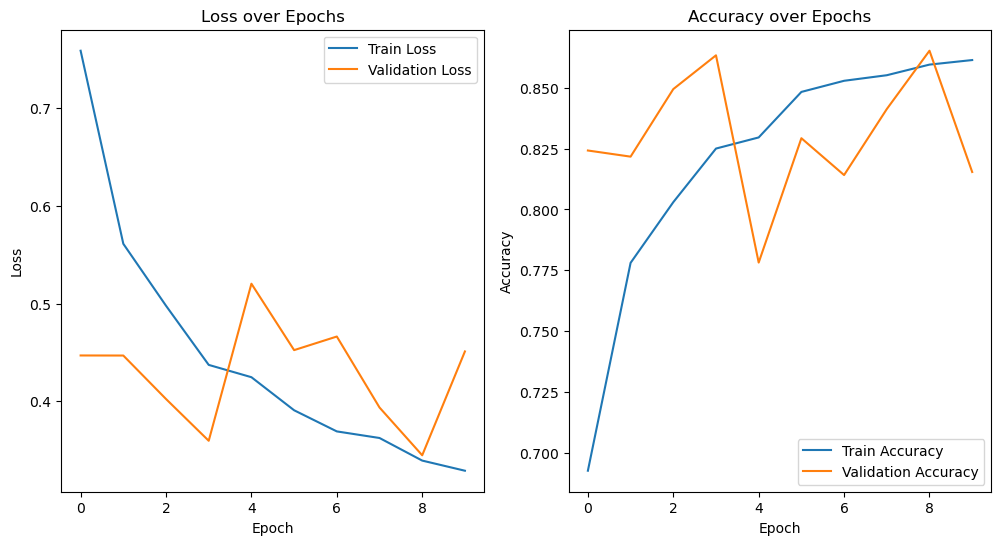

In [16]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Testing: 100%|██████████| 398/398 [00:47<00:00,  8.33it/s]

Test Loss: 0.4243, Test Accuracy: 0.8270, Test F1 Score: 0.8295


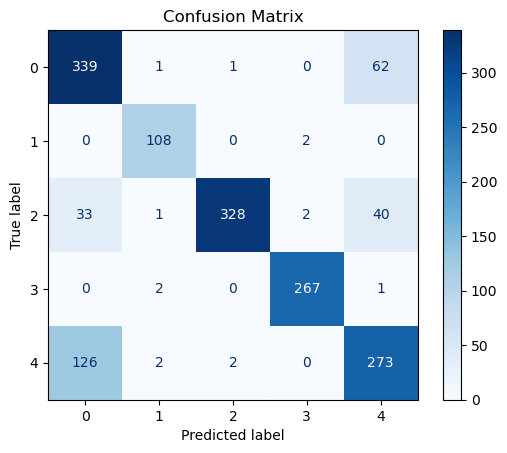

In [18]:
# Test the model and return labels and predictions for confusion matrix
def test_model(test_dl, model):
    model.eval()
    test_loss, test_correct = 0, 0
    test_labels, test_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            test_correct += (preds == labels).type(torch.float).sum().item()
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(preds.cpu().numpy())

    test_accuracy = test_correct / len(test_dl.dataset)
    test_f1_score = f1_score(test_labels, test_preds, average='weighted')
    return test_loss / len(test_dl), test_accuracy, test_f1_score, test_labels, test_preds

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_f1_score, test_labels, test_preds = test_model(test_dl, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1_score:.4f}")

# Now display the confusion matrix
def display_confusion_matrix(test_labels, test_preds):
    cm = confusion_matrix(test_labels, test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to display the confusion matrix
display_confusion_matrix(test_labels, test_preds)
